<a href="https://colab.research.google.com/github/liranpod/KerasBinary/blob/main/KerasBinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import packages.

In [172]:
# Data and preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error


In [173]:
# Neural network

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

Load data.

In [174]:
loan_data = pd.read_csv("https://raw.githubusercontent.com/liranpod/KerasBinary/main/Loan_Data.csv")

# Quick inspection

print(loan_data.head())
print(loan_data.columns)
print(loan_data.dtypes)

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

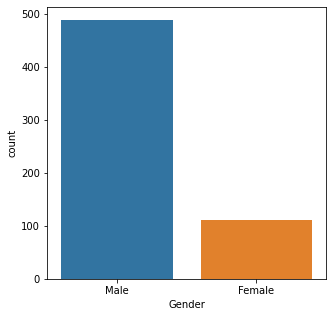

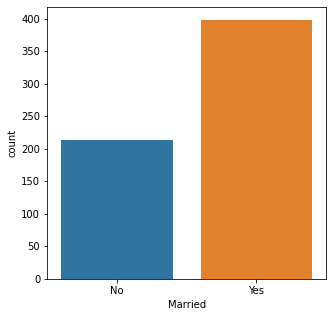

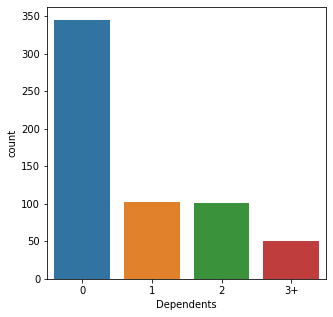

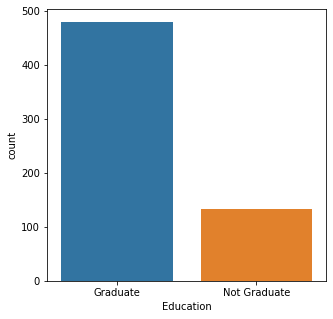

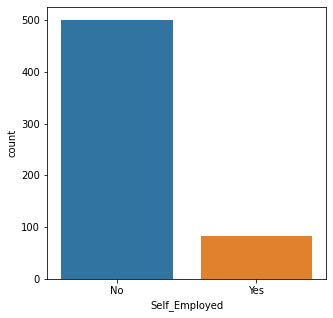

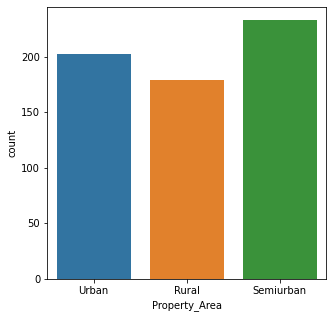

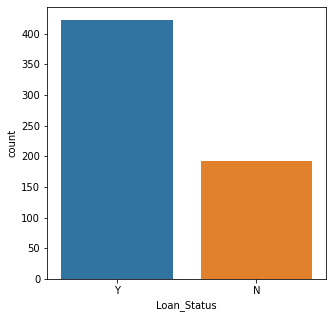

In [175]:
NotCategorical = ["Loan_ID", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

for i in list(loan_data.keys()):
  if i not in NotCategorical:
    plt.figure(figsize=(5,5))
    sns.countplot(x=loan_data[i])
    plt.show()


Preprocessing.

In [176]:
print(loan_data.isnull().values.any())
print(loan_data.duplicated())



Numerical = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]
Categorical = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "Property_Area"]

Numerical_transformer = make_pipeline(
    SimpleImputer(strategy="constant"),
    StandardScaler(),
)
Categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)
preprocessor = make_column_transformer(
    (Numerical_transformer, Numerical),
    (Categorical_transformer, Categorical),
)

features = Numerical + Categorical

X = loan_data[features]
y = loan_data["Loan_Status"]
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
y = lb.fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, random_state=0)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

print(X_train.shape)


True
0      False
1      False
2      False
3      False
4      False
       ...  
609    False
610    False
611    False
612    False
613    False
Length: 614, dtype: bool
(491, 24)


Model.

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_163 (Ba  (None, 24)               96        
 tchNormalization)                                               
                                                                 
 dense_162 (Dense)           (None, 256)               6400      
                                                                 
 batch_normalization_164 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_105 (Dropout)       (None, 256)               0         
                                                                 
 dense_163 (Dense)           (None, 256)               65792     
                                                                 
 batch_normalization_165 (Ba  (None, 256)            

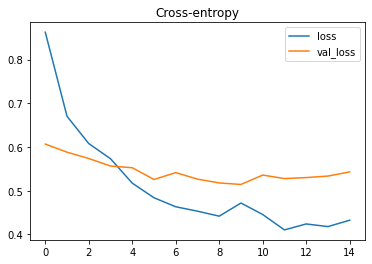

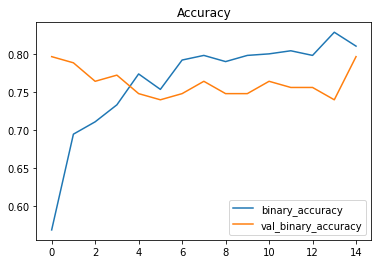

In [180]:
input_shape = [X_train.shape[1]]

model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['binary_accuracy'],)

early_stopping = keras.callbacks.EarlyStopping(
   patience=5,
   min_delta=0.001,
   restore_best_weights=True,
)

history = model.fit(
  X_train, y_train,
  validation_data=(X_valid, y_valid),
  batch_size=32,
  epochs=50,
  callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
